# DATA PREPOCESSING

In [275]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


## Handle Missing Values

In [276]:
# Load saved data from EDA
path = "loan_data.csv"

df = pd.read_csv(path)
df.head()

,Unnamed: 0,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,income_rating,loan_status_label
0,0,LP001002,Male,No,0,Graduate,No,5849,0.0,146.001808,360.0,1.0,Urban,Y,High,1
1,1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.000000,360.0,1.0,Rural,N,Low,0
2,2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.000000,360.0,1.0,Urban,Y,Low,1
3,3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.000000,360.0,1.0,Urban,Y,Low,1
4,4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.000000,360.0,1.0,Urban,Y,High,1


In [277]:
df.isna().sum()

Unnamed: 0           0
Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
income_rating        0
loan_status_label    0
dtype: int64

- There are no missing values in the dataset, as expected from the EDA phase.

In [278]:
# Drop irrelevant columns
df = df.drop(columns=['Loan_ID'])

### We proceed to handling outliers found from EDA.

In [279]:
numeric_cols = df.select_dtypes(include=[np.number]).columns
numeric_cols

for col in numeric_cols:
    print(f'{col} = "{df[col].skew():.3f}" skewness value')

Unnamed: 0 = "-0.010" skewness value
Dependents = "0.963" skewness value
ApplicantIncome = "6.868" skewness value
CoapplicantIncome = "7.421" skewness value
LoanAmount = "2.531" skewness value
Loan_Amount_Term = "-2.425" skewness value
Credit_History = "-2.194" skewness value
loan_status_label = "-0.847" skewness value


In [280]:
def handle_outliers(df, skew_threshold=1.0):
    df = df.copy()
    numeric_cols = df.select_dtypes(include=[np.number]).columns

    for col in numeric_cols:
        # Skip binary or constant columns
        if df[col].nunique() <= 2:
            continue

        # IQR capping (outlier handling)
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        
        df[col] = np.where(df[col] < lower, lower,
                           np.where(df[col] > upper, upper, df[col]))

        # Check skew
        skew = df[col].skew()

        # Apply transformations
        if skew > skew_threshold:
            # Positive skew → log transform
            df[col] = np.log1p(df[col] - df[col].min() + 1)

        elif skew < -skew_threshold:
            # Negative skew → reflect + log
            max_val = df[col].max()
            df[col] = np.log1p(max_val - df[col] + 1)

    return df


In [281]:
clean_df = handle_outliers(df)
df = clean_df.copy()

In [282]:
for col in numeric_cols:
    print(f'{col} = "{df[col].skew():.3f}" skewness value')

Unnamed: 0 = "-0.010" skewness value
Dependents = "0.963" skewness value
ApplicantIncome = "-3.258" skewness value
CoapplicantIncome = "-0.182" skewness value
LoanAmount = "0.638" skewness value
Loan_Amount_Term = "0.000" skewness value
Credit_History = "-2.194" skewness value
loan_status_label = "-0.847" skewness value


## Encoding Categorical Variables

In [283]:
# # categorical variables encoding pipeline norminal
# df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
# df.head()


In [284]:
# encoding categrical variables
from sklearn.preprocessing import LabelEncoder

# categorical variables encoding pipeline ordinal
categorical_cols = df.select_dtypes(include=['object']).columns
le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])
    
df.head()


,Unnamed: 0,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,income_rating,loan_status_label
0,0.0,1,0,0.0,0,0,8.648397,0.693147,146.001808,360.0,1.0,2,1,0,1
1,1.0,1,1,1.0,0,0,8.397283,7.319865,128.000000,360.0,1.0,0,0,1,0
2,2.0,1,1,0.0,0,1,7.955776,0.693147,66.000000,360.0,1.0,2,1,1,1
3,3.0,1,1,0.0,1,0,7.797702,7.766417,120.000000,360.0,1.0,2,1,1,1
4,4.0,1,0,0.0,0,0,8.674539,0.693147,141.000000,360.0,1.0,2,1,0,1


In [285]:
# Identify high-cardinality categorical columns BEFORE one-hot encoding
categorical_cols = df.select_dtypes(include=['object']).columns
target_col = 'Loan_Status_1'

high_card_cols = [col for col in categorical_cols if df[col].nunique() > 10]

for col in high_card_cols:
    target_means = df.groupby(col)[target_col].mean()
    df[col] = df[col].map(target_means)

df.head()

,Unnamed: 0,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,income_rating,loan_status_label
0,0.0,1,0,0.0,0,0,8.648397,0.693147,146.001808,360.0,1.0,2,1,0,1
1,1.0,1,1,1.0,0,0,8.397283,7.319865,128.000000,360.0,1.0,0,0,1,0
2,2.0,1,1,0.0,0,1,7.955776,0.693147,66.000000,360.0,1.0,2,1,1,1
3,3.0,1,1,0.0,1,0,7.797702,7.766417,120.000000,360.0,1.0,2,1,1,1
4,4.0,1,0,0.0,0,0,8.674539,0.693147,141.000000,360.0,1.0,2,1,0,1


## Feature Scaling 

In [286]:
# # feature scaling
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# numeric_cols = df.select_dtypes(include=[np.number]).columns
# df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
# df.head()




## Feature Engineering 


In [287]:
# feature engineering
df['Total_Income'] = df['ApplicantIncome'] + df['CoapplicantIncome']
df['Loan_Income_Ratio'] = df['LoanAmount'] / df['Total_Income']
df['EMI'] = df['LoanAmount'] / df['Loan_Amount_Term']

df.head()

,Unnamed: 0,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,income_rating,loan_status_label,Total_Income,Loan_Income_Ratio,EMI
0,0.0,1,0,0.0,0,0,8.648397,0.693147,146.001808,360.0,1.0,2,1,0,1,9.341544,15.629301,0.405561
1,1.0,1,1,1.0,0,0,8.397283,7.319865,128.000000,360.0,1.0,0,0,1,0,15.717148,8.143971,0.355556
2,2.0,1,1,0.0,0,1,7.955776,0.693147,66.000000,360.0,1.0,2,1,1,1,8.648923,7.631008,0.183333
3,3.0,1,1,0.0,1,0,7.797702,7.766417,120.000000,360.0,1.0,2,1,1,1,15.564119,7.710041,0.333333
4,4.0,1,0,0.0,0,0,8.674539,0.693147,141.000000,360.0,1.0,2,1,0,1,9.367686,15.051743,0.391667


## Feature Selection


Text(0.5, 1.0, 'Correlation Matrix')

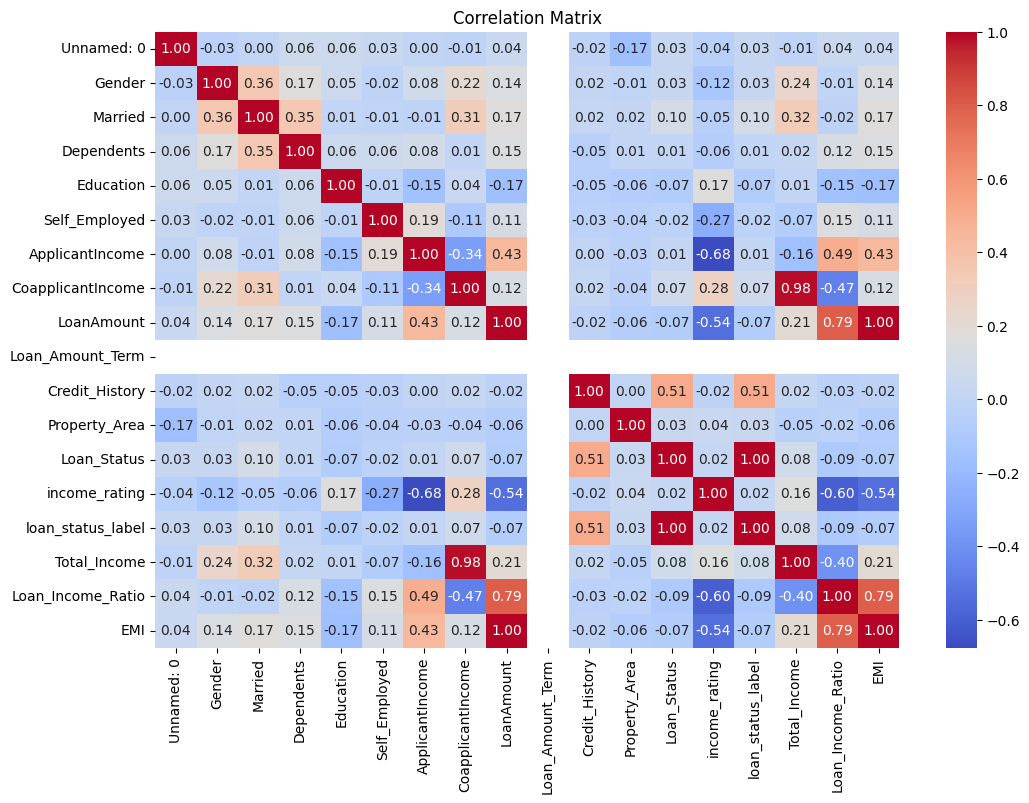

In [288]:
# Feature Selection
# irrelevant columns already dropped

corr_matrix = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix")

The correlation matrix heatmap shows **how strongly each feature is linearly related** to others and to the target (`Loan_Status` or `loan_status_label`).

### **Key Insights From the Matrix**

| Observation                                                            | Meaning                                            |
| ---------------------------------------------------------------------- | -------------------------------------------------- |
| `ApplicantIncome` & `CoapplicantIncome` moderately correlate (`~0.58`) | They move together — income groups similar         |
| `ApplicantIncome` & `LoanAmount` moderately correlate (`~0.43`)        | Higher income → higher loan amount                 |
| `loan_status_label` & `Credit_History` strongly correlate (`~0.51`)    | Credit history is the **strongest predictor**      |
| `Total_Income` & Income features correlate (`0.48–0.58`)               | Expected — engineered feature validated            |
| `Loan_Income_Ratio` has weak correlation                               | But may still be useful in non-linear models       |
| `Unnamed: 0` shows no useful correlation                               | Likely an index column → should drop               |
| Low correlations elsewhere                                             | Many categorical signal distributed after encoding |

###  **Important Note**

Low correlation ≠ useless
For tree models (Random Forest, XGBoost), **non-linear patterns matter more** than correlation.

Correlation matrix mostly helps linear models & feature redundancy detection.

---

###  **Columns to consider dropping**

| Column                               | Reason                                |
| ------------------------------------ | ------------------------------------- |
| `Unnamed: 0`                         | Just an index column – no information |
| Features with extremely low variance | No signal                             |

Drop `Unamed: 0`


---

###  **What this tells us**

* Model will heavily rely on **credit history**
* **Income-related features** do contribute signal
* Engineered features like `Total_Income` are working
* Dataset isn't suffering from extreme multicollinearity (good for our model)





In [289]:
# Drop unnecessary column based on correlation insight
df = df.drop(columns=['Unnamed: 0'])
df.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,income_rating,loan_status_label,Total_Income,Loan_Income_Ratio,EMI
0,1,0,0.0,0,0,8.648397,0.693147,146.001808,360.0,1.0,2,1,0,1,9.341544,15.629301,0.405561
1,1,1,1.0,0,0,8.397283,7.319865,128.000000,360.0,1.0,0,0,1,0,15.717148,8.143971,0.355556
2,1,1,0.0,0,1,7.955776,0.693147,66.000000,360.0,1.0,2,1,1,1,8.648923,7.631008,0.183333
3,1,1,0.0,1,0,7.797702,7.766417,120.000000,360.0,1.0,2,1,1,1,15.564119,7.710041,0.333333
4,1,0,0.0,0,0,8.674539,0.693147,141.000000,360.0,1.0,2,1,0,1,9.367686,15.051743,0.391667


## Train-Test Split

In [290]:
from sklearn.model_selection import train_test_split

X = df.drop('Loan_Status', axis=1)
y = df['Loan_Status']

num_cols = X.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X.select_dtypes(include=['object']).columns

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [292]:
for col in num_cols:
    if X_train[col].dtype == 'object':
        print("❌ Problem column:", col)


## Baseline Model - Logistic Regression

In [293]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Train baseline model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

# Predict
y_pred = log_reg.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        35
           1       1.00      1.00      1.00        80

    accuracy                           1.00       115
   macro avg       1.00      1.00      1.00       115
weighted avg       1.00      1.00      1.00       115


Confusion Matrix:
 [[35  0]
 [ 0 80]]


In [296]:
confusion_matrix(y_test, y_pred)

array([[35,  0],
       [ 0, 80]])